In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib


print("Количество доступных GPU:", len(tf.config.list_physical_devices('GPU')))
print("==========")
print(*device_lib.list_local_devices(), sep="\n==========\n")
print("==========")

Количество доступных GPU: 1
name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5819520521315971906
xla_global_id: -1

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2915198567
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1300970808560380562
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419



In [2]:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=16, inter_op_parallelism_threads=16)
sess = tf.compat.v1.Session(config=session_conf)

In [3]:
import random
import gym
import time
import numpy as np
from collections import deque
from keras.models import Model, load_model
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


def show(rendered):
    clear_output(wait=True)
    plt.imshow(rendered)
    plt.show()

### [Инициализация среды](https://www.gymlibrary.dev/environments/classic_control/pendulum/)

In [4]:
N_OUTPUT_DISCRETIZATION = 32
environment = gym.make("Pendulum-v1", g=9.81, render_mode="rgb_array")

##### Нейросеть 512-256-128

In [5]:
input_layer = Input(environment.observation_space.shape)
output_layer = Dense(512, activation="relu", kernel_initializer="he_uniform")(input_layer)
output_layer = Dense(256, activation="relu", kernel_initializer="he_uniform")(output_layer)
output_layer = Dense(128, activation="relu", kernel_initializer="he_uniform")(output_layer)

# линейная активация выходного слоя
output_layer = Dense(N_OUTPUT_DISCRETIZATION, activation="linear", kernel_initializer="he_uniform")(output_layer)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss="mse", optimizer=RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

In [6]:
class DQNAgent:
    def __init__(self, model, environment):
        self.model = model
        self.environment = environment
        self.state_size = self.environment.observation_space.shape[0]
        self.action_size = self.environment.action_space.shape[0]
        self.EPISODES = 200
        self.memory = deque(maxlen=2000)
        self.gamma = 0.98 # discount rate
        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.9999
        self.batch_size = 256
        self.train_start = 1000
        self.discretizer = KBinsDiscretizer(
            n_bins=N_OUTPUT_DISCRETIZATION, encode="ordinal", strategy="uniform"
        ).fit([[-2], [2]])        
        


    def remember(self, state, action_selector, reward, next_state):
        self.memory.append((state, action_selector, reward, next_state))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                
                
    def select_action(self, state):
        if np.random.random() <= self.epsilon:
            return self.environment.action_space.sample() # исследование - выбрать случайное действие
        
        # эксплуатация - выбрать действие, предсказанное нейросетью
        return self.discretizer.inverse_transform([[np.argmax(model.predict(state, verbose=0)[0])]])[0]
    
    
    def restudy(self):
        if len(self.memory) < self.train_start:
            return

        minibatch = np.array(random.sample(self.memory, min(len(self.memory), self.batch_size)))
        
        state = np.array(minibatch[:, 0].tolist()).reshape(-1, minibatch[:, 0][0].shape[1])
        action_selectors = minibatch[:, 1]
        reward = minibatch[:, 2]
        next_state = np.array(minibatch[:, 3].tolist()).reshape(-1, minibatch[:, 3][0].shape[1])        

        q_values = self.model.predict(state, verbose=0)
        next_q_values = self.model.predict(next_state, verbose=0)        
        for i in range(self.batch_size):
            q_values[i][action_selectors[i]] = reward[i] + self.gamma * (np.max(next_q_values[i]))
            
        self.model.fit(state, q_values, batch_size=self.batch_size, verbose=0)        
        
        
    def study(self):
        for episode in range(self.EPISODES):
            self.run()
            print("episode: {}/{}, epsilon: {:.2}".format(episode, self.EPISODES, self.epsilon))
                
                
    def run(self, with_animation=False):
        state = self.environment.reset()[0].reshape(1, self.state_size)
        done = False
        while not done:
            action = self.select_action(state)
            next_state, reward, terminated, done, _ = self.environment.step(action)
            next_state = next_state.reshape(1, self.state_size)
            self.remember(state, self.discretizer.transform([action])[0].astype("int")[0], reward, next_state)
            state = next_state
            if with_animation:
                show(self.environment.render())
                time.sleep(0.01)
            for _ in range(10):
                self.restudy()

In [7]:
agent = DQNAgent(model, environment)

In [8]:
%%time
agent.study()

episode: 0/200, epsilon: 1.0
episode: 1/200, epsilon: 1.0
episode: 2/200, epsilon: 1.0
episode: 3/200, epsilon: 1.0
episode: 4/200, epsilon: 1.0
episode: 5/200, epsilon: 0.98
episode: 6/200, epsilon: 0.96
episode: 7/200, epsilon: 0.94
episode: 8/200, epsilon: 0.92
episode: 9/200, epsilon: 0.9
episode: 10/200, epsilon: 0.89
episode: 11/200, epsilon: 0.87
episode: 12/200, epsilon: 0.85
episode: 13/200, epsilon: 0.84
episode: 14/200, epsilon: 0.82
episode: 15/200, epsilon: 0.8
episode: 16/200, epsilon: 0.79
episode: 17/200, epsilon: 0.77
episode: 18/200, epsilon: 0.76
episode: 19/200, epsilon: 0.74
episode: 20/200, epsilon: 0.73
episode: 21/200, epsilon: 0.71
episode: 22/200, epsilon: 0.7
episode: 23/200, epsilon: 0.68
episode: 24/200, epsilon: 0.67
episode: 25/200, epsilon: 0.66
episode: 26/200, epsilon: 0.64
episode: 27/200, epsilon: 0.63
episode: 28/200, epsilon: 0.62
episode: 29/200, epsilon: 0.61
episode: 30/200, epsilon: 0.59
episode: 31/200, epsilon: 0.58
episode: 32/200, epsilon: 

KeyboardInterrupt: 

### Проверка обученного агента

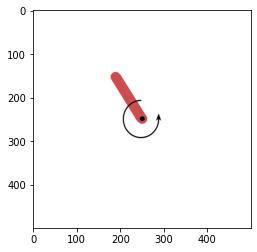

In [ ]:
agent.run(with_animation=True)
environment.close()